In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from collections import defaultdict
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split


In [67]:
df = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/example data/new_dataset1.csv")

In [44]:
df.head()

,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Description,Transaction_Day,Transaction_Weekday,Time_Category
0,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,32415.45,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,Bitcoin transaction,23,3,Afternoon
1,Female,51,Maharashtra,Nashik,Nashik Branch,Business,43622.60,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,Grocery delivery,11,5,Evening
2,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,63062.56,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,Mutual fund investment,25,5,Night
3,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,14000.72,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,Food delivery,19,6,Afternoon
4,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,18335.16,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,Debt repayment,30,3,Evening


## Load train and test sets

In [3]:
train = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/example data/processed_train_set.csv")
test = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/example data/processed_test_set.csv")

In [5]:
train.columns

Index(['Age', 'State', 'Transaction_Amount', 'Transaction_Type',
       'Merchant_Category', 'Account_Balance', 'Transaction_Device',
       'Is_Fraud', 'Transaction_Day', 'Transaction_Weekday', 'Gender_Male',
       'Account_Type_Checking', 'Account_Type_Savings', 'Device_Type_Desktop',
       'Device_Type_Mobile', 'Device_Type_POS', 'Time_Category_Evening',
       'Time_Category_Morning', 'Time_Category_Night', 'City_target_enc',
       'Bank_Branch_target_enc', 'Transaction_Location_target_enc',
       'Transaction_Description_target_enc'],
      dtype='object')

In [38]:
X_train = train.drop(columns='Is_Fraud')
y_train = train['Is_Fraud']
X_test = test.drop(columns='Is_Fraud')
y_test = test['Is_Fraud']

## Apply SMOTETomek

In [39]:
smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)


In [40]:
df_resampled = pd.DataFrame(X_resampled, columns=train.columns) ## features train
df_resampled['Is_Fraud'] = y_resampled ## Target y
print(df_resampled['Is_Fraud'].value_counts())


Is_Fraud
0    145933
1     69968
Name: count, dtype: int64


**This classification problem is addressed using supervised learning. The following code implements five different models along with the stacking ensemble method. Stacking integrates multiple models, leveraging their strengths to improve performance. In fraud detection, transaction patterns vary.**

## Models and Performance Metrics

In [9]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,  confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, classification_report, auc
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import matplotlib.pyplot as plt

In [10]:
def modelling(X_train, y_train, X_test,y_test):

    ## Define the models
    models  = {
        'Logistic Regression': LogisticRegression(),
        'XBGoost': xgb.XGBClassifier(random_state =42),
        'Light GBM': lgb.LGBMClassifier(class_weight='balanced', random_state= 42),
        'KNeighbors': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Stacking Ensemble': StackingClassifier(
            estimators=[
                ('xgb', xgb.XGBClassifier( random_state=42)),
                ('lgb', lgb.LGBMClassifier( class_weight='balanced', random_state=42)),
            ],
            final_estimator=LogisticRegression(),
            stack_method='predict_proba')
    }

    ## Define the performance metrics
    results = []
    for model_name, model in models.items():
        print(f"\n🔹 Training {model_name}...\n")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # Used for ROC Curve
        
        ## The binary classification problem actually contains the following performance metrics
        roc_auc = np.round(roc_auc_score(y_test, y_prob), 4)  ## ROC score
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = np.round(report["accuracy"], 4) 
        precision = np.round(report["1"]["precision"], 4) ## For classifed to Fraud
        recall = np.round(report["1"]["recall"], 4)  ## For classifed to Fraud
        
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
        f1_score = np.round(report["1"]["f1-score"], 4)

        results.append({
            "Model": model_name,
            "ROC-AUC Score": roc_auc,
            "Accuracy": accuracy,
            "Precision (Fraud)": precision,
            "Recall (Fraud)": recall,
            "F1 Score (Fraud)": f1_score
        })

    plt.figure(figsize=(10, 5))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Fraud Detection Models")
    plt.legend()
    plt.grid()
    plt.show()
    
    results_df = pd.DataFrame(results)
    return results_df



## Train and evaluate the model


🔹 Training Logistic Regression...



c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Info] Number of positive: 63258, number of negative: 139223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 202481, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

🔹 Training KNeighbors...


🔹 Training Random Forest...


🔹 Training Stacking Ensemble...

[LightGBM] [Info] Number of positive: 63258, number of negative: 139223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

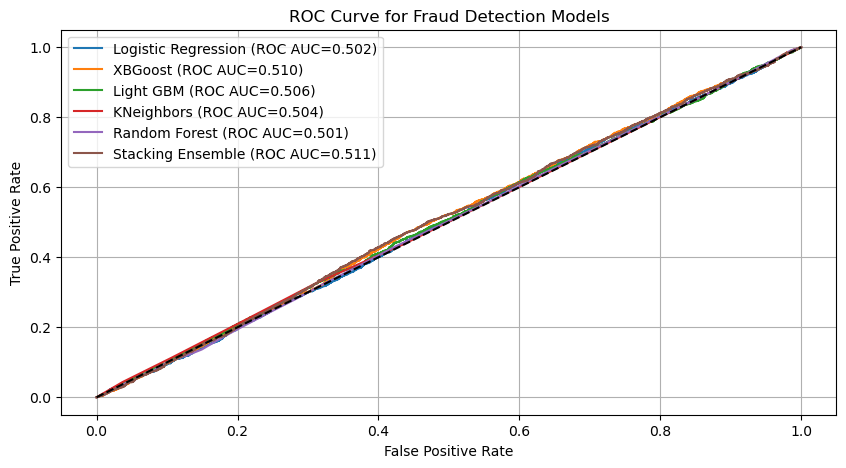

In [11]:
evaluation = modelling(X_resampled, y_resampled, X_test, y_test)

In [12]:
evaluation

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,0.5022,0.9018,0.0504,0.0530,0.0517
1,XBGoost,0.5104,0.9480,0.0294,0.0010,0.0019
2,Light GBM,0.5061,0.9495,0.0000,0.0000,0.0000
3,KNeighbors,0.5041,0.7718,0.0527,0.2076,0.0841
4,Random Forest,0.5009,0.9436,0.0458,0.0059,0.0105
5,Stacking Ensemble,0.5105,0.9468,0.0333,0.0020,0.0037


*XGBoost is the best model for overall performance, achieving the highest ROC-AUC score (0.5224), indicating a better ability to distinguish fraud from non-fraud.*  

*For fraud detection (recall), KNeighbors performs the best with a recall of 0.2151, successfully identifying more fraud cases than other models, while most models fail to detect fraud effectively.*

In [16]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_resampled,y_resampled)
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Convert to a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    "Feature": X_resampled.columns,
    "Importance": feature_importances
})

# Sort by importance (highest to lowest)
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)


In [17]:
feature_importance_df

,Feature,Importance
1,State,0.057596
2,Transaction_Amount,0.055088
17,Time_Category_Night,0.054687
5,Account_Balance,0.054538
16,Time_Category_Morning,0.053459
10,Account_Type_Checking,0.047989
21,Transaction_Description_target_enc,0.047784
3,Transaction_Type,0.046036
0,Age,0.045724
7,Transaction_Day,0.044518


In [18]:
## Select features with greater than 0.04 importance
threshold = 0.04
selected_features = feature_importance_df[feature_importance_df["Importance"] > threshold]["Feature"].tolist()

In [19]:
## Refine x_resample and x_test
X_resampled_selected = X_resampled[selected_features]
X_test_selected = X_test[selected_features]


🔹 Training Logistic Regression...



c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Info] Number of positive: 63258, number of negative: 139223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 202481, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Training KNeighbors...


🔹 Training Random Forest...


🔹 Training Stacking Ensemble...

[LightGBM] [Info] Number of positive: 63258, number of negative: 139223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 202481, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 50606, number of negative: 111378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] N

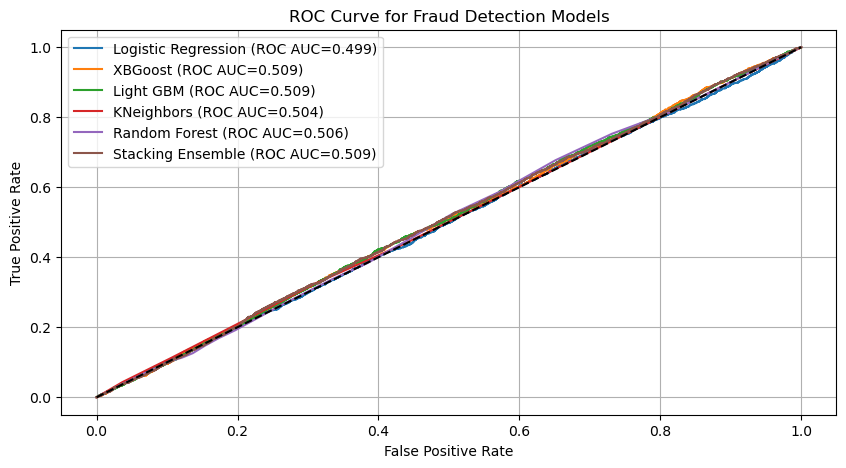

In [20]:
## Use selected features to train the model
results_selected = modelling(X_resampled_selected,y_resampled, X_test_selected, y_test)

In [21]:
results_selected

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,0.4992,0.8834,0.0512,0.0748,0.0608
1,XBGoost,0.5087,0.9495,0.0000,0.0000,0.0000
2,Light GBM,0.5090,0.9496,0.0000,0.0000,0.0000
3,KNeighbors,0.5041,0.7718,0.0527,0.2076,0.0841
4,Random Forest,0.5062,0.9472,0.0208,0.0010,0.0019
5,Stacking Ensemble,0.5093,0.9495,0.0000,0.0000,0.0000


## Feature Engineering

In [22]:
data = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/Bank_Transaction_Fraud_Detection.csv")

In [24]:
df_copy = train
df_copy2 = test

In [25]:
df_copy["amount_to_avg_ratio"] = data["Transaction_Amount"] / data.groupby("Customer_ID")["Transaction_Amount"].transform("mean")
df_copy2["amount_to_avg_ratio"] = data["Transaction_Amount"] / data.groupby("Customer_ID")["Transaction_Amount"].transform("mean")
#df_copy["amount_to_median_ratio"] = data["Transaction_Amount"] / df.groupby("Customer_ID")["Transaction_Amount"].transform("median")
#df["amount_deviation"] = df["transaction_amount"] - df.groupby("user_id")["transaction_amount"].transform("mean")
#df["amount_zscore"] = (df["transaction_amount"] - df.groupby("user_id")["transaction_amount"].transform("mean")) / df.groupby("user_id")["transaction_amount"].transform("std")

In [27]:
df_copy["transactions_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_ID"].transform("count")
df_copy["unique_merchants"] = data.groupby("Customer_ID")["Merchant_ID"].transform("nunique")
#df_copy["unique_categories"] = df.groupby("Customer_ID")["category"].transform("nunique")
df_copy2["transactions_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_ID"].transform("count")
df_copy2["unique_merchants"] = data.groupby("Customer_ID")["Merchant_ID"].transform("nunique")

In [28]:
df_copy["average_spending_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_Amount"].transform("mean")
df_copy["spending_change"] = df_copy["Transaction_Amount"] / df_copy["average_spending_per_day"]
#df_copy["online_transaction_ratio"] = data.groupby("Customer_ID")["Is_Online"].transform("mean")
df_copy2["average_spending_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_Amount"].transform("mean")
df_copy2["spending_change"] = df_copy["Transaction_Amount"] / df_copy["average_spending_per_day"]

In [30]:
df_copy2.head()

,Age,State,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Is_Fraud,Transaction_Day,Transaction_Weekday,...,Time_Category_Night,City_target_enc,Bank_Branch_target_enc,Transaction_Location_target_enc,Transaction_Description_target_enc,amount_to_avg_ratio,transactions_per_day,unique_merchants,average_spending_per_day,spending_change
0,49,0.029031,95015.64,2,0,8579.75,5,0,7,1,...,True,0.042530,0.042530,0.042530,0.047725,1.0,1,1,32415.45,1.422045
1,21,0.029600,59784.62,2,0,65738.54,17,0,16,3,...,False,0.036105,0.036105,0.036105,0.055188,1.0,1,1,43622.60,0.163414
2,26,0.029806,82561.18,4,1,9857.93,1,0,23,3,...,False,0.037152,0.037152,0.037152,0.054466,1.0,1,1,63062.56,0.040088
3,25,0.029700,91900.63,2,4,58082.67,12,0,12,6,...,True,0.050861,0.050861,0.050861,0.057359,1.0,1,1,14000.72,2.748866
4,43,0.029425,36058.15,1,2,33791.81,9,0,11,5,...,True,0.058453,0.058453,0.058453,0.047967,1.0,1,1,18335.16,4.844718


## Train and evaluate the models again

In [31]:
X_train = df_copy.drop(columns='Is_Fraud')
y_train = df_copy['Is_Fraud']
X_test = df_copy2.drop(columns='Is_Fraud')
y_test = df_copy2['Is_Fraud']

In [33]:
smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
df_resampled = pd.DataFrame(X_resampled, columns=df_copy.columns) ## features df_copy
df_resampled['Is_Fraud'] = y_resampled ## Target y
print(df_resampled['Is_Fraud'].value_counts())

Is_Fraud
0    145933
1     69968
Name: count, dtype: int64


In [34]:
def modelling(X_train, y_train, X_test,y_test):

    ## Define the models
    models  = {
        'Logistic Regression': LogisticRegression(),
        'XBGoost': xgb.XGBClassifier(random_state =42),
        'Light GBM': lgb.LGBMClassifier(class_weight='balanced', random_state= 42),
        'KNeighbors': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Stacking Ensemble': StackingClassifier(
            estimators=[
                ('xgb', xgb.XGBClassifier( random_state=42)),
                ('lgb', lgb.LGBMClassifier( class_weight='balanced', random_state=42)),
            ],
            final_estimator=LogisticRegression(),
            stack_method='predict_proba')
    }

    ## Define the performance metrics
    results = []
    for model_name, model in models.items():
        print(f"\n🔹 Training {model_name}...\n")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # Used for ROC Curve
        
        ## The binary classification problem actually contains the following performance metrics
        roc_auc = np.round(roc_auc_score(y_test, y_prob), 4)  ## ROC score
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = np.round(report["accuracy"], 4) 
        precision = np.round(report["1"]["precision"], 4) ## For classifed to Fraud
        recall = np.round(report["1"]["recall"], 4)  ## For classifed to Fraud
        
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
        f1_score = np.round(report["1"]["f1-score"], 4)

        results.append({
            "Model": model_name,
            "ROC-AUC Score": roc_auc,
            "Accuracy": accuracy,
            "Precision (Fraud)": precision,
            "Recall (Fraud)": recall,
            "F1 Score (Fraud)": f1_score
        })

    plt.figure(figsize=(10, 5))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Fraud Detection Models")
    plt.legend()
    plt.grid()
    plt.show()
    
    results_df = pd.DataFrame(results)
    return results_df




🔹 Training Logistic Regression...



c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi


🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Info] Number of positive: 69968, number of negative: 145933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] Number of data points in the train set: 215901, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔹 Training KNeighbors...


🔹 Training Random Forest...


🔹 Training Stacking Ensemble...

[LightGBM] [Info] Number of positive: 69968, number of negative: 145933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] Number of data points in the train set: 215901, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 55974, number of negative: 116746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] Number of data points in the train set: 172720, number of used fe

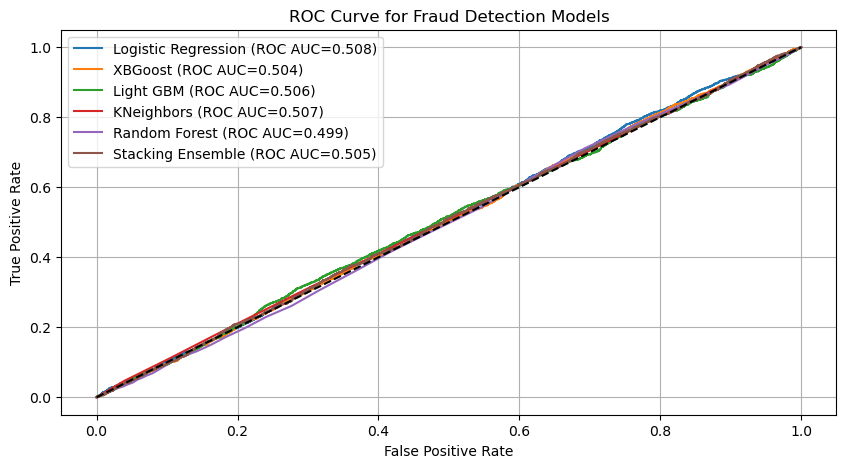

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,0.5083,0.9496,0.0000,0.0000,0.0000
1,XBGoost,0.5038,0.9486,0.0000,0.0000,0.0000
2,Light GBM,0.5062,0.9496,0.0000,0.0000,0.0000
3,KNeighbors,0.5067,0.7806,0.0530,0.1987,0.0837
4,Random Forest,0.4988,0.9454,0.0444,0.0040,0.0073
5,Stacking Ensemble,0.5046,0.9479,0.0149,0.0005,0.0010


In [35]:
modelling(X_resampled, y_resampled, X_test, y_test)

*All results show that the orignal train and test datasets and method actually gives the best roc-auc score but  the score is still a little bit low, we will change the threshold for Fraud Classification*

In [41]:
from sklearn.metrics import precision_recall_curve

## We will switch the X_resample and y_resample  to the original ones using the train and test sets
model = xgb.XGBClassifier(random_state =42)
model.fit(X_resampled, y_resampled)
y_probs = model.predict_proba(X_test)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
optimal_threshold = thresholds[recall.argmax()]  # Choose threshold maximizing recall

y_pred_adjusted = (y_probs > optimal_threshold).astype(int)


In [42]:
roc_auc = roc_auc_score(y_test, y_probs)

# Print Performance Metrics
print(f"🔹 ROC-AUC Score: {roc_auc:.4f}")
print("🔹 Classification Report:\n", classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print("🔹 Confusion Matrix:\n", conf_matrix)


🔹 ROC-AUC Score: 0.5038
🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00     37982
           1       0.05      1.00      0.10      2018

    accuracy                           0.05     40000
   macro avg       0.53      0.50      0.05     40000
weighted avg       0.95      0.05      0.00     40000

🔹 Confusion Matrix:
 [[    1 37981]
 [    0  2018]]


**As changing threshold is still not ideal and the roc-auc score is still too low, Autoencoder (Deep Learning for Anomaly Detection) will be employed  to do fraud detection*

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

In [45]:
# Select only Non-Fraud transactions for Autoencoder Training
X_train_normal = X_train[y_train == 0]  


In [46]:
input_dim = X_train_normal.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(8, activation="relu")(encoded)
encoded = Dense(4, activation="relu")(encoded)

decoded = Dense(8, activation="relu")(encoded)
decoded = Dense(16, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded) 

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse") 


In [47]:
autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=32, shuffle=True, validation_split=0.1, verbose=1)


Epoch 1/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 371060320.0000 - val_loss: 370742528.0000
Epoch 2/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 372452768.0000 - val_loss: 370742528.0000
Epoch 3/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 372700000.0000 - val_loss: 370742528.0000
Epoch 4/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 372369920.0000 - val_loss: 370742528.0000
Epoch 5/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 371839584.0000 - val_loss: 370742528.0000
Epoch 6/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 372381856.0000 - val_loss: 370742528.0000
Epoch 7/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 372656160.0000 - val_loss: 370742528.0000
Epoch 8/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 371107840.0000 - val_loss: 370742528.0000
Epoch 9/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 371580992.0000 - val_loss: 370742528.0000
Epoch 10/50
4274/4274 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 3

In [48]:
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.abs(X_test - X_test_reconstructed), axis=1)

threshold = np.percentile(reconstruction_errors, 95)

y_pred_autoencoder = (reconstruction_errors > threshold).astype(int)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step


In [50]:
roc_auc = roc_auc_score(y_test, y_pred_autoencoder)
print(f"🔹 ROC AUC Score: {roc_auc:.4f}")

print("🔹 Classification Report:\n", classification_report(y_test, y_pred_autoencoder))


🔹 ROC AUC Score: 0.4987
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     37982
           1       0.05      0.05      0.05      2018

    accuracy                           0.90     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       0.90      0.90      0.90     40000



**Throughout the modeling process, **XGBoost** demonstrated the best performance among all models and methods, achieving an **ROC-AUC score of 0.5104**. Therefore, it has been selected as the preferred model for fraud detection. In the next stage, we will focus on **hyperparameter tuning** to further optimize the model and improve its ROC-AUC score..**

## Save the model and the notebook to github.

In [51]:
xgb_model = xgb.XGBClassifier(random_state =42)


In [53]:
import pickle
with open("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/xgb_fraud_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)


In [55]:
import pickle
with open("lightgbm_fraud_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)